@chhy

Compared to the simple version, full version might have a better performance in case of complicate or intense angular distortion. The size of model W will grow during iterations, and fudge will also change. More options for envelope.

Fine tuning needed.

In [1]:

# load the necessary packages

import numpy as np
import os, sys

import matplotlib.pyplot as plt
plt.ion()
from IPython.display import display, clear_output

sys.path.append('./Tool_box/')

from utilbcid_without_omega import C, M
from utilbcid_without_omega import generate_initial, generate_envelope, pre_align_rolls


## Single scan to test the parameters

In [2]:
# basic parameter

shape = 128
scan = 6

data_root = './Data/pick_up/'
data_file = data_root + '%i_%i.npz'%(scan, shape)
save_root = './Data/EMC_results/'
save_filename = save_root + 'corr_%i.npz'%scan
save_figname = save_root + 'corr_%i.png'%scan

Nj = 20
Nj_max = 128
increase_Nj_every = 5

fudge = 5e-4
fudge_max = 5e-3
increase_fudge_every = 10
increase_fudge_by = 2**(1/2)

num_iter = Nj_max +25

support = 0.5

In [3]:
# initialize the data and model 

data = np.load(data_file)['data']
print (data.shape)
W = generate_initial(data, Nj)

# Option 1 for envelop2: according to the dataset itself:
envelope = generate_envelope(Nj, data.shape[-1], support=(support, 1, 1))

# Option 2 for envelope: according to the geometry (Q space) and the real size of the sample
# e.g.: Golden nanoparticle with 60 nm diameter:
a = 4.065e-10
E = 10000   
d = a / np.sqrt(3) # (111)
hc = 4.136e-15 * 3.000e8
theta = np.arcsin(hc / (2 * d * E)) / np.pi * 180
psize = 55e-6
distance = .25
# detector plane: dq = |k| * dtheta(pixel-pixel)
Q12 = psize * 2 * np.pi / distance / (hc / E) * data.shape[-1]
Q3 = Q12 / 128 * 25  # about the same Q range as the first in-plane minimum 
dq3 = Q3 / Nj
Dmax = 60e-9
#envelope = generate_envelope(Nj, data.shape[-1], Q=(Q3, Q12, Q12), Dmax=(Dmax, 1, 1), theta=theta)

(700, 128, 128)


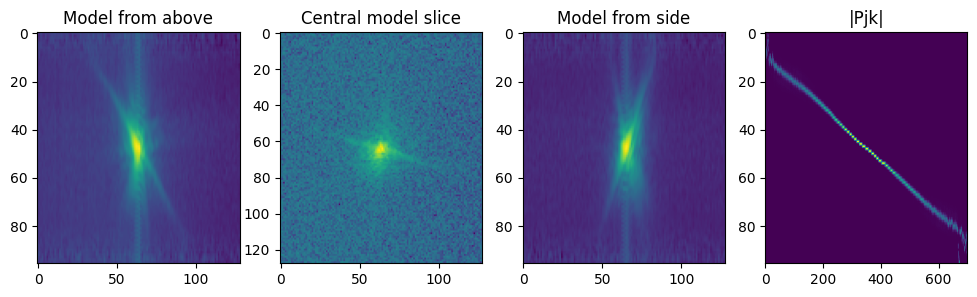

increased Nj to 100
101


In [ ]:

fig, ax = plt.subplots(ncols=4, figsize=(12, 3))
titles = ['Model from above', 'Central model slice', 'Model from side', '|Pjk|']
errors = []

for i in range(num_iter):
    print(i)
    W, Pjk, timing = M(W, data , beta=fudge,
                        force_continuity=6, nproc=8,
                        find_direction=(i>10))
    #[print(k, '%.3f'%v) for k, v in timing.items()]
    W, error = C(W, envelope) 
    errors.append(error)
    
    clear_output(wait=True)  # Clear the output to remove the old figures/text
    fig.clf()  # Clear the figure to refresh plots
    ax = fig.subplots(ncols=4)  # Re-create axes

    # Update plots
    #ax[0].imshow(np.log10(W[:, W.shape[1]//2, :]), cmap='viridis', aspect='auto')
    ax[0].imshow(np.log10(np.sum(W, axis = 1)), cmap='viridis', aspect='auto')
    ax[1].imshow(np.log10(W[W.shape[0]//2, :, :]), cmap='viridis', aspect='auto')
    ax[2].imshow(np.log10(np.sum(W, axis = 2)), cmap='viridis', aspect='auto')
    ax[3].imshow(np.abs(Pjk), aspect='auto', cmap='viridis')
    #ax[3].plot(errors)

    # Update titles
    for j, title in enumerate(titles):
        ax[j].set_title(title)

    # Redisplay the figure
    display(fig)  # Display the updated figure
    plt.pause(0.1)  # Pause to allow update before next iteration
    if i and (Nj<Nj_max) and (i % increase_Nj_every) == 0:
        W = np.pad(W, ((2,2),(0,0),(0,0)))
        Nj = W.shape[0]
        Q3 = dq3 * Nj
        #envelope = generate_envelope(Nj, data.shape[-1], Q=(Q3, Q12, Q12), Dmax=(Dmax, 1, 1), theta=theta)
        envelope = generate_envelope(Nj, data.shape[-1], support=(support, 1, 1))
        print('increased Nj to %u'%Nj)

    if i and (fudge < fudge_max) and (i % increase_fudge_every) == 0:
        fudge *= increase_fudge_by
        print('increased fudge to %e'%fudge)

In [ ]:
#save option
np.savez(save_filename,  W=W, Pjk=Pjk, support=support)